In [30]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os

from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame

import warnings
warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb

In [3]:
store = pd.read_csv('./Data/store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
train = pd.read_csv('./Data/train.csv',index_col='Date',parse_dates=True)
test = pd.read_csv('./Data/test.csv')

# A) Explorative Datenanalyse

In [6]:
train.head(5).append(train.tail(5))

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [7]:
train.shape

(1017209, 8)

Über 1 Mio. Beobachtungen von Verkaufsdaten zwischen 2013-2015 (Zeitreihendaten) 

Wir müssen Feature-Engineering anwenden, um die Analyse zu vereinfachen

In [8]:
#Extrahiere Jahr, Monat, Tag und Woche - Erstelle new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

train['SalePerCustomer'] = train['Sales']/train['Customers']

array([[<AxesSubplot:title={'center':'DayOfWeek'}>]], dtype=object)

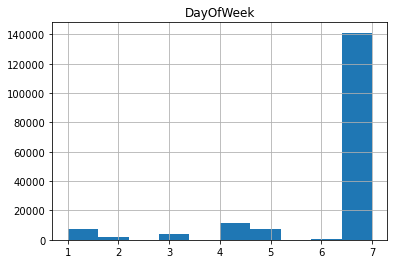

In [9]:
train_store_closed = train[(train.Open == 0)]
train_store_closed.hist('DayOfWeek') 
#Tage an dem Store geschlossen war / sehen am 7 Tag zu -- Sonntag (macht Sinn)

In [10]:
train.isnull().sum()

Store                   0
DayOfWeek               0
Sales                   0
Customers               0
Open                    0
Promo                   0
StateHoliday            0
SchoolHoliday           0
Year                    0
Month                   0
Day                     0
WeekOfYear              0
SalePerCustomer    172869
dtype: int64

In [11]:
# anzahl tage mit geschlossenen Stores
train[(train.Open == 0)].shape[0]

172817

In [12]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
#Nur 3 Werte bei 'CompetitionDistance' fehlen / Median ersetzen 
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

#Keine Infos über andere Spalten - replace by 0
store.fillna(0, inplace=True)

In [14]:
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [15]:
test.fillna(1, inplace=True) # Annahme, Stores im Test geöffnet

In [16]:
#Tabelle verbinden 
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [17]:
#Verteilung von Verkäufern & Kunden auf verschiedene Filialtypen
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalePerCustomer'].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


In [18]:
# Geöffnet & Sales >0 Stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]

## Korrelationsanalyse

<AxesSubplot:>

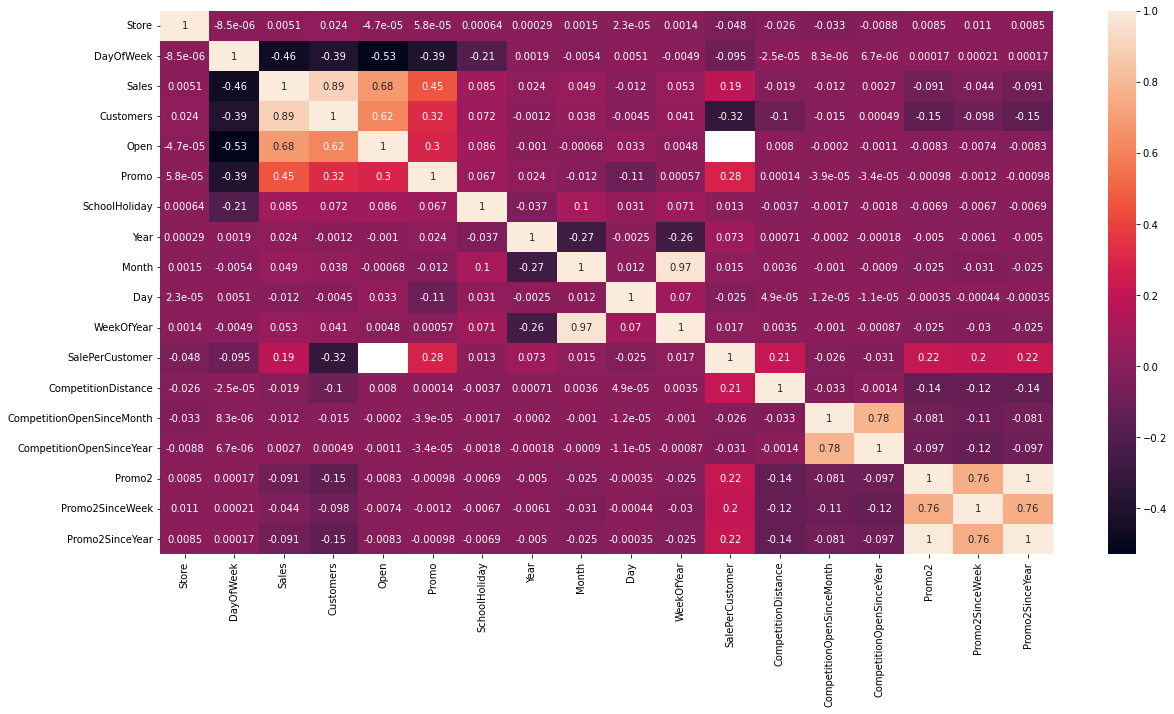

In [19]:
# Korrelation
plt.figure(figsize = (20, 10))
sns.heatmap(train_store_joined.corr(), annot = True)

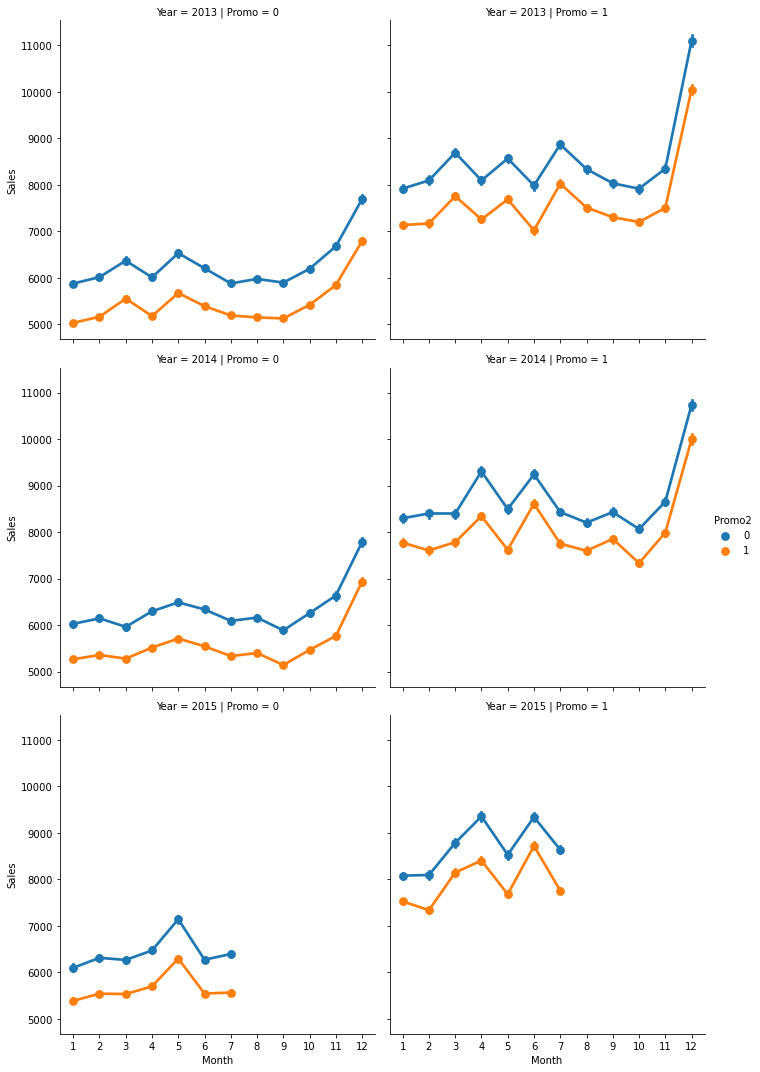

In [20]:
#Verkaufstrend über die Monate
sns.factorplot(data = train_store_joined_open, x="Month", y="Sales",
                col= 'Promo', #pro Filialtyp in Spalte
                hue= 'Promo2',
                row= 'Year')

### Fazit von EDA

- Meisterverkaufte & überfüllteste StoreType ist A

- StoreType B hat den höchsten Sale pro Kunde

# B) Zeitreihenanalyse & Predictive Modelling

## Zeitreihenanalyse

In [21]:
pd.plotting.register_matplotlib_converters()

<AxesSubplot:xlabel='Date'>

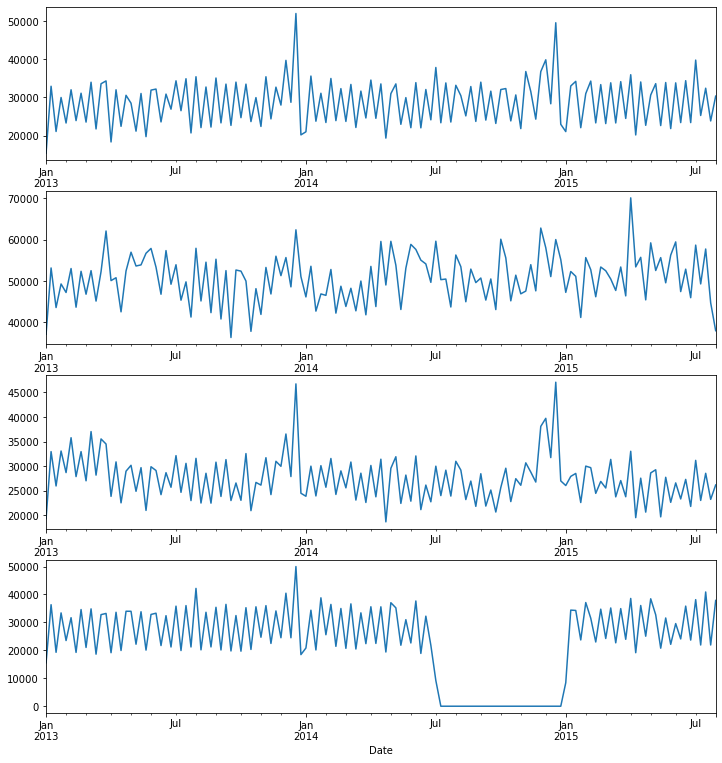

In [22]:
#Datenaufbereitung: Input sollte float sein
train['Sales'] = train['Sales'] * 1.0 

#Zuweisung eines Shops aus jeder Kategorie 
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

Aus den obigen Diagrammen können wir sehen, dass die Verkäufe für StoreType A und C am Ende des Jahres (Weihnachtszeit) ihren Höhepunkt erreichen und dann nach den Feiertagen zurückgehen. Wir können keinen ähnlichen Trend in StoreType D erkennen, da für diesen Zeitraum keine Daten verfügbar sind (Stores geschlossen)

### Stationarität von Zeitreihen

Um Zeitreihenprognosemodelle verwenden zu können, müssen wir sicherstellen, dass unsere Zeitreihendaten stationär sind, d. h. konstanter Mittelwert, konstante Varianz und konstante Kovarianz mit der Zeit.

Es gibt zwei Arten um Stationarität in Zeitreihen zu testen 1) Rolling Mean - Visualisierung 2) Dicky-Fuller Test - statistischer Test

In [23]:
#Funk. fürs Testen
def test_stationarität(timeseries):

    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    orig = plt.plot(timeseries.resample('W').mean(), color='blue', label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling         Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling       Std')
    plt.legend(loc='best')
    plt.show(block=False)

    # Performing Dickey-Fuller test:
    print('Resultate von Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

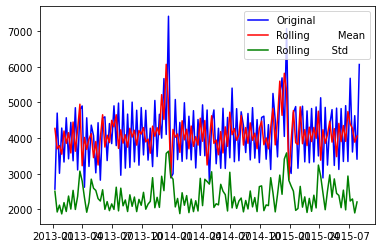

Resultate von Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [24]:
#Test Stationarität von StoreType A
test_stationarität(sales_a)

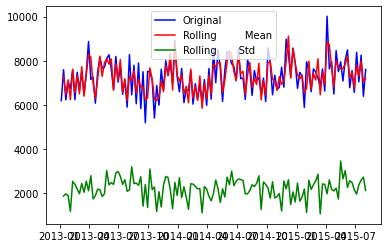

Resultate von Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [25]:
#Test Stationarität von StoreType B
test_stationarität(sales_b)

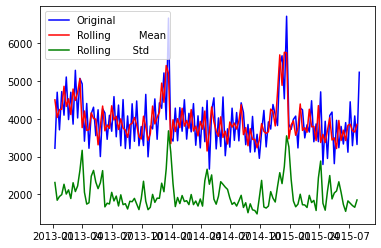

Resultate von Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [26]:
#Test Stationarität von StoreType C
test_stationarität(sales_c)

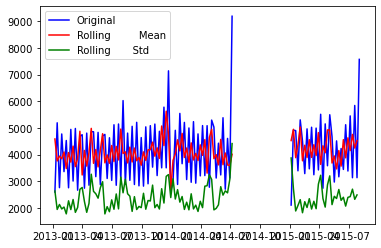

Resultate von Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [27]:
#Test Stationarität von StoreType D
test_stationarität(sales_d)

Wir sehen, dass sich der Mittelwert und Variation mit der Zeit nicht viel ändern - d.h. sie sind konstant. Daher brauchen wir keine Transformation

In [35]:
seasonal_decompose

<function statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)>

In [40]:
#Plotte Saisonalität und Trends 
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive')#,freq=365) 

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

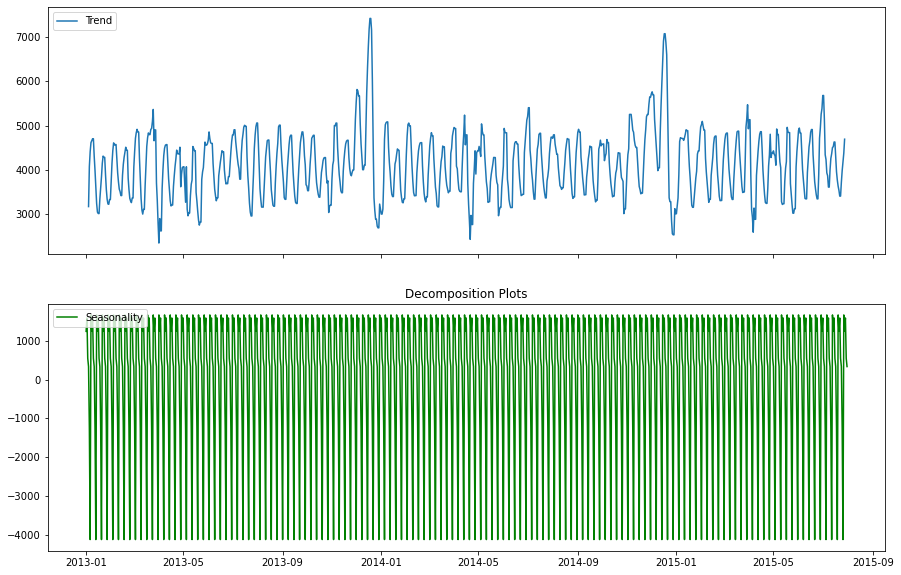

In [41]:
#Saisonalität & Trend von A
plot_timeseries(sales_a, 'a')

## Forecasting einer Zeitreihe

### Bewertungsmetriken

RMSE - Root Mean Square Error

### Modell 1 - SARIMA

In [42]:
# Autorrelations Fkt zur Erstellung von ACF & PACF Graphen
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

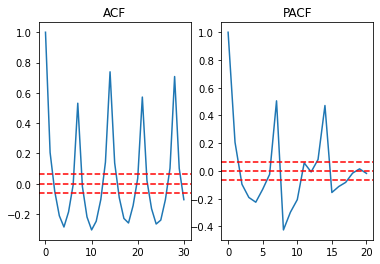

In [43]:
# ACF & PACF für StoreType A
auto_corr(sales_a)

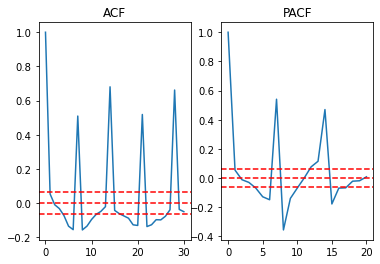

In [44]:
# ACF & PACF für StoreType B
auto_corr(sales_b)

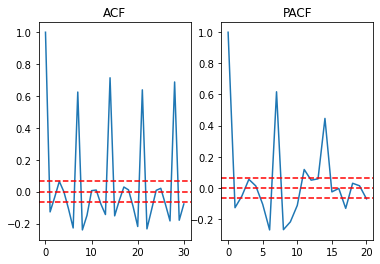

In [45]:
# ACF & PACF für StoreType C
auto_corr(sales_c)

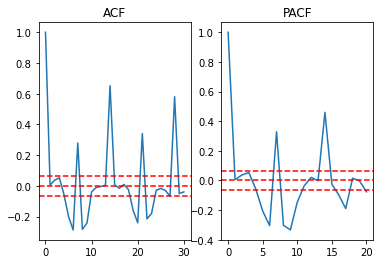

In [46]:
# ACF & PACF für StoreType D
auto_corr(sales_d)

Sehen, dass p=2 und q=2 sind aber wir machen noch einen GridSearch, um zu sehen, welche Kombination von p,q und d das niedrigste AIC (gibt uns die Qualität der Modelle) ergibt. Das beste Modell verwendet die geringste Anzahl von Features

<AxesSubplot:xlabel='Date'>

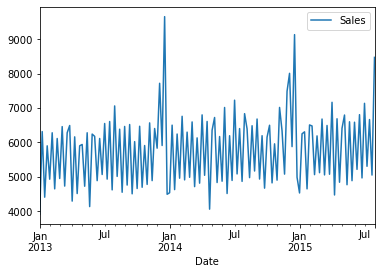

In [47]:
#Gesamte Datensatz 
train_arima = train.resample("W").mean()
train_arima = train_arima[["Sales"]]
train_arima.plot()

Verwende GridSearch für die beste Kombination

In [48]:
#Def. p,d und q -- random wert zwischen 0 und 3
p = d = q = range(0,2)

#Erzeuge vers. Kombinationen von p-, d- und q-Tripletts
pdq = list(itertools.product(p,d,q))

#Erzeuge vers. Kombinationen von saisonalen p,d,q Trip
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Bspe für Parms Kombination für Saisonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Bspe für Parms Kombination für Saisonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Iteriere, um zu sehen, welche Kombi den niedrigsten AIC Score hat

In [49]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00253D+01    |proj g|=  7.03615D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.036D-07   1.003D+01
  F =   10.025257915386275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   6.833D-05   7.817D+00
  F =   7.8174288565457877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.7057912673627
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.09609D+00    |proj g|=  5.42766D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.59335D+00    |proj g|=  6.54328D-01

At iterate   25    f=  8.51810D+00    |proj g|=  2.52475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     32      1     0     0   6.396D-06   8.518D+00
  F =   8.5180993722390905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305045544
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77688D+00    |proj g|=  9.84237D-02

           * 

 This problem is unconstrained.



At iterate   15    f=  6.90528D+00    |proj g|=  4.61506D-02

At iterate   20    f=  6.86877D+00    |proj g|=  1.88392D-01

At iterate   25    f=  6.85420D+00    |proj g|=  1.87136D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   1.871D-05   6.854D+00
  F =   6.8542049109856995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.635325966139
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  7.92666D+00    |proj g|=  1.52610D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     42      1     0     0   4.722D-07   7.926D+00
  F =   7.9260837671708337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617136125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11826D+00    |proj g|=  5.54771D+00

At iterate    5    f=  8.66302D+00    |proj g|=  1.86604D-01

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.04536D+00    |proj g|=  1.89481D-02

At iterate   15    f=  7.02875D+00    |proj g|=  9.37628D-02

At iterate   20    f=  7.02386D+00    |proj g|=  7.97673D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   7.977D-07   7.024D+00
  F =   7.0238574406488885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089752
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     22      1     0     0   1.880D-06   7.965D+00
  F =   7.9651127896040386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.5804531930903
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36765D+00    |proj g|=  3.08320D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2023.1445509589184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41842D+00    |proj g|=  9.87275D-02

At iterate    5    f=  7.29373D+00    |proj g|=  3.80065D-04

At iterate   10    f=  7.29373D+00    |proj g|=  2.37862D-03

At iterate   15    f=  7.29297D+00    |proj g|=  3.24351D-02

At iterate   20    f=  7.25553D+00    |proj g|=  1.36915D-01

At iterate   25    f=  7.24385D+00    |proj g|=  2.24771D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.44707D+00    |proj g|=  9.52806D-02

At iterate   30    f=  7.44409D+00    |proj g|=  5.75898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     36      1     0     0   5.233D-06   7.444D+00
  F =   7.4440889857130852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2015.904026142533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97390D+00    |proj g|=  4.80230D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.99318D+00    |proj g|=  4.36825D-03

At iterate   15    f=  6.99188D+00    |proj g|=  8.96739D-02

At iterate   20    f=  6.84372D+00    |proj g|=  2.41959D-01

At iterate   25    f=  6.78542D+00    |proj g|=  1.14557D-01

At iterate   30    f=  6.77952D+00    |proj g|=  1.90177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     41      1     0     0   1.902D-05   6.780D+00
  F =   6.7795153883315296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1836.469154849513
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.49840D+00    |proj g|=  1.48126D-02

At iterate   10    f=  7.49477D+00    |proj g|=  5.03705D-02

At iterate   15    f=  7.49440D+00    |proj g|=  3.67239D-04

At iterate   20    f=  7.49433D+00    |proj g|=  4.50464D-03

At iterate   25    f=  7.49038D+00    |proj g|=  4.15601D-02

At iterate   30    f=  7.44229D+00    |proj g|=  4.53848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     38      1     0     0   6.318D-06   7.442D+00
  F =   7.4422605197169354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2017.410340323

 This problem is unconstrained.



At iterate    0    f=  7.26171D+00    |proj g|=  5.01656D-01

At iterate    5    f=  7.16788D+00    |proj g|=  1.86817D-02

At iterate   10    f=  7.16779D+00    |proj g|=  9.31686D-04

At iterate   15    f=  7.16743D+00    |proj g|=  2.54788D-02

At iterate   20    f=  7.14481D+00    |proj g|=  3.24616D-01

At iterate   25    f=  7.05966D+00    |proj g|=  1.50655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     37      1     0     0   2.371D-07   7.060D+00
  F =   7.0596531717490798     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1912.106356372

 This problem is unconstrained.



At iterate   10    f=  6.99155D+00    |proj g|=  6.32209D-03

At iterate   15    f=  6.99145D+00    |proj g|=  4.72283D-04

At iterate   20    f=  6.99142D+00    |proj g|=  9.84306D-03

At iterate   25    f=  6.98659D+00    |proj g|=  1.35886D-01

At iterate   30    f=  6.82806D+00    |proj g|=  2.14469D-01

At iterate   35    f=  6.77422D+00    |proj g|=  3.48036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     51      1     0     0   1.712D-06   6.774D+00
  F =   6.7742168082295589     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1837.038538221

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.02642D+00    |proj g|=  1.92692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   9.459D-06   8.026D+00
  F =   8.0264175771008279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2173.1327458172236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77047D+00    |proj g|=  6.50475D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.02081D+00    |proj g|=  1.45703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.366D-05   8.021D+00
  F =   8.0207865652389554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2173.612372614518
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92042D+00    |proj g|=  1.83538D-02

At iterate    5    f=  6.92005D+00    |proj g|=  1.57508D-03

At iterate   1

 This problem is unconstrained.



At iterate   20    f=  6.89339D+00    |proj g|=  3.33188D-02

At iterate   25    f=  6.88342D+00    |proj g|=  1.75637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.599D-05   6.883D+00
  F =   6.8831057706675258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1866.438558080232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46944D+00    |proj g|=  2.06548D+01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.59973D+00    |proj g|=  1.84847D+00

At iterate   10    f=  7.55798D+00    |proj g|=  2.86514D+00

At iterate   15    f=  7.55686D+00    |proj g|=  1.17717D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     61      2     0     0   1.177D-02   7.557D+00
  F =   7.5568571322888074     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2048.3514257179777
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68595D+00    |proj g|=  2.84555D-02

At iterate    5    f=  7.68577D+00    |proj g|=  2.26768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.



At iterate    5    f=  7.92951D+00    |proj g|=  2.58401D-01

At iterate   10    f=  7.77496D+00    |proj g|=  5.14153D+00

At iterate   15    f=  7.62879D+00    |proj g|=  2.19146D+00

At iterate   20    f=  7.61958D+00    |proj g|=  8.16991D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     55      1     0     0   4.332D-02   7.620D+00
  F =   7.6195652019051368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2065.282604514387
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67831D+00    |proj g|=  4.87710D-01

At iterate    5    f=  7.62440D+00    |proj g|=  2.49697D-01

At iterate   10    f=  7.59237D+00    |proj g|=  1.50366D-01

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  6.90291D+00    |proj g|=  1.41205D-03

At iterate   15    f=  6.90274D+00    |proj g|=  1.87475D-02

At iterate   20    f=  6.89251D+00    |proj g|=  8.27242D-02

At iterate   25    f=  6.89020D+00    |proj g|=  3.78350D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     30      1     0     0   1.931D-06   6.890D+00
  F =   6.8902011004241901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1868.3542971145314


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83485D+00    |proj g|=  9.55212D-02

At iterate    5    f=  6.82476D+00    |proj g|=  3.00588D-03

At iterate   10    f=  6.82473D+00    |proj g|=  1.89333D-04

At iterate   15    f=  6.82468D+00    |proj g|=  5.31960D-03

At iterate   20    f=  6.82022D+00    |proj g|=  8.24579D-02

At iterate   25    f=  6.79835D+00    |proj g|=  1.06023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2032.2056460425276
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85646D+00    |proj g|=  1.41529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.415D-05   7.856D+00
  F =   7.8564580252301717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2125.2436668121463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00064D+00    |proj g|=  7.56974D-02

At iterate    5    f=  6.99733D+00    |proj g|=  2.15363D-04

At iterate   10    f=  6.99730D+00    |proj g|=  6.05172D-03

At iterate   15    f=  6.99453D+00    |proj g|=  5.79801D-02

At iterate   20    f=  6.98818D+00    |proj g|=  2.07120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   3.763D-06   6.988D+00
  F =   6.9881756054761643     

CONVERG

 This problem is unconstrained.



At iterate   20    f=  6.90458D+00    |proj g|=  7.40651D-02

At iterate   25    f=  6.83492D+00    |proj g|=  6.13718D-02

At iterate   30    f=  6.83138D+00    |proj g|=  3.55671D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   3.557D-06   6.831D+00
  F =   6.8313807424500110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1852.472800461503
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.30831D+00    |proj g|=  1.58672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   8.592D-05   7.308D+00
  F =   7.3083139102632826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1981.2447557710864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69926D+00    |proj g|=  1.06824D-01

At iterate    5    f=  7.69068D+00    |proj g|=  4.40964D-05

           * 

 This problem is unconstrained.



At iterate   10    f=  6.75937D+00    |proj g|=  6.65520D-04

At iterate   15    f=  6.75929D+00    |proj g|=  1.25665D-02

At iterate   20    f=  6.74866D+00    |proj g|=  1.65249D-01

At iterate   25    f=  6.66927D+00    |proj g|=  6.47137D-02

At iterate   30    f=  6.66036D+00    |proj g|=  2.26731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     35      1     0     0   1.613D-06   6.660D+00
  F =   6.6603636691492136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.2981906702878
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.31440D+00    |proj g|=  4.42802D-02

At iterate   10    f=  7.30694D+00    |proj g|=  2.57385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   9.548D-05   7.307D+00
  F =   7.3069339953087153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1982.8721787333532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91158D+00    |proj g|=  8.94723D-02

At iterate   

 This problem is unconstrained.



At iterate   15    f=  6.89632D+00    |proj g|=  1.93136D-03

At iterate   20    f=  6.89088D+00    |proj g|=  6.18410D-02

At iterate   25    f=  6.87132D+00    |proj g|=  5.32070D-03

At iterate   30    f=  6.87127D+00    |proj g|=  1.12088D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   1.121D-07   6.871D+00
  F =   6.8712720472180067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1863.2434527488617
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  6.75837D+00    |proj g|=  3.27961D-02

At iterate   10    f=  6.75654D+00    |proj g|=  3.67519D-04

At iterate   15    f=  6.75653D+00    |proj g|=  1.71456D-03

At iterate   20    f=  6.75499D+00    |proj g|=  2.96720D-02

At iterate   25    f=  6.65882D+00    |proj g|=  5.07756D-02

At iterate   30    f=  6.65686D+00    |proj g|=  4.77241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   1.601D-05   6.657D+00
  F =   6.6568479290517830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1807.348940843

ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1852.472800461503 - Beste Kombi

### Modell Fitting

In [50]:
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78887D+00    |proj g|=  1.47334D-01

At iterate    5    f=  6.75939D+00    |proj g|=  3.75184D-03

At iterate   10    f=  6.75937D+00    |proj g|=  6.65520D-04

At iterate   15    f=  6.75929D+00    |proj g|=  1.25665D-02


 This problem is unconstrained.



At iterate   20    f=  6.74866D+00    |proj g|=  1.65249D-01

At iterate   25    f=  6.66927D+00    |proj g|=  6.47137D-02

At iterate   30    f=  6.66036D+00    |proj g|=  2.26731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     35      1     0     0   1.613D-06   6.660D+00
  F =   6.6603636691492136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323


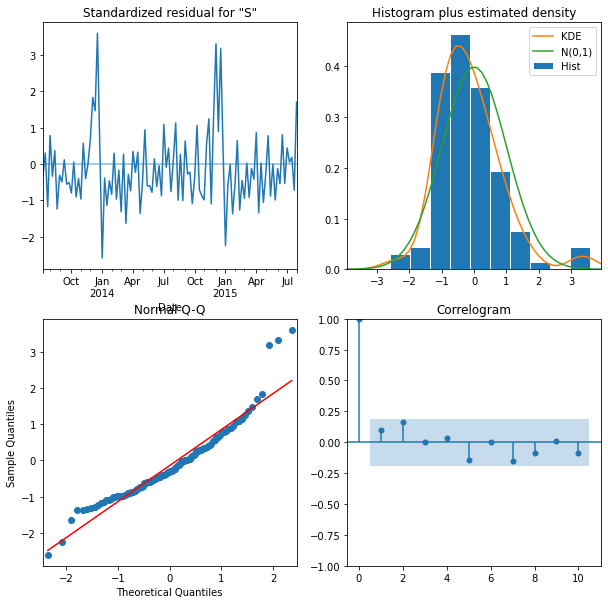

In [51]:
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

Plots: KDE & N(0,1) ähnlich - Normal Q Q Diagramm zeigt, die geordnete Vert. der Residuen der Vert. ähnlich der Normalvert. folgt. --- Unser Modell ist ziemlich gut

Standardisierte Residuendiagramm: Sagt aus, dass es keine größeren Saisonalitätstrend gibt, was durch Autokorrelationsdiagramm bestätigt wird Autokorrelationsdiagramm: sagt aus, dass die Zeitreihenresiduen eine geringe Korrelation mit verzögerten Versionen von sich selbst aufweisen

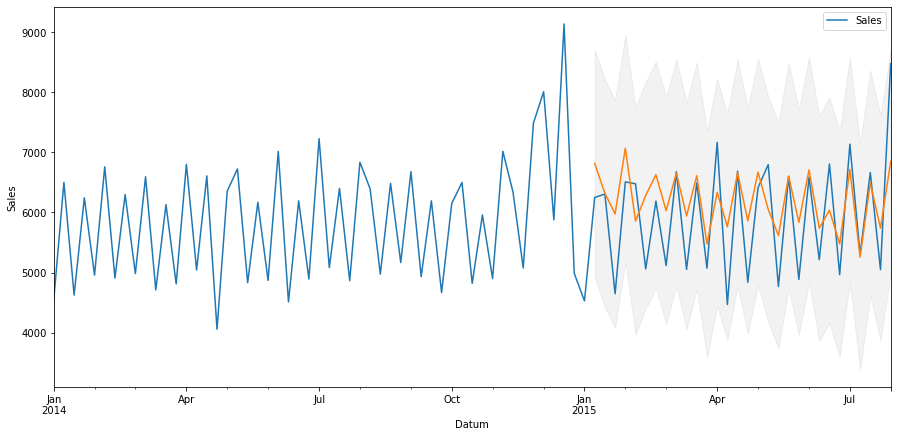

Root Mean Squared Error:  739.0611703774467


In [52]:
#Modellvorhersage und -validierung
#Vorhersage ab dem 11. Januar 2015

pred = results_sarima.get_prediction(start= pd.to_datetime('2015-01-11'),dynamic=False)

#Konfidenzintervalle von Forecasts
pred_ci = pred.conf_int()


ax = train_arima["2014":].plot(label = "beobachtet", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "Vorhersage n+1", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Datum")
ax.set_ylabel("Sales")

plt.legend
plt.show()


train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Berechne Error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

### Modell 2 - XGBoost

Um XGBoost anzuwenden, müssen alle kategorialen Var. in numerische/Dummy Var. umgewandelt werden. Lösche auch korrelierte Spalten (z.B. Kunden, Verkauf pro Kunde) joine ähnliche Spaten (CompetitionOpen..)

In [53]:
#Lösche: Kunden & Verkauf pro Kunde
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)


#Kombiniere ähnliche und lösche alte Spalten
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)



#Konvertiere kategorische Spalten in numerische & lösche alte Spalten
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)


#Splitte Daten
features = ts_xgboost.drop(['Sales'], axis=1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features,target,test_size=0.20)

In [54]:
#Paramtuning 
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Training
xgboost = xgb.train(params, dtrain, 100, evals=watchlist, early_stopping_rounds=100,verbose_eval=True)

#Predictions
preds = xgboost.predict(dtest)

[16:01:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:5164.92432	eval-rmse:5154.07959
[1]	train-rmse:4013.24658	eval-rmse:4001.13477
[2]	train-rmse:3295.47290	eval-rmse:3281.99365
[3]	train-rmse:2876.66821	eval-rmse:2863.44312
[4]	train-rmse:2636.85547	eval-rmse:2624.14258
[5]	train-rmse:2497.38477	eval-rmse:2484.80103
[6]	train-rmse:2425.82861	eval-rmse:2413.71606
[7]	train-rmse:2385.75903	eval-rmse:2373.83691
[8]	train-rmse:2312.06616	eval-rmse:2301.08472
[9]	train-rmse:2287.13965	eval-rmse:2276.94189
[10]	train-rmse:2265.29199	eval-rmse:2256.69580
[11]	train-rmse:2238.24072	eval-rmse:2229.84326
[12]	train-rmse:2222.68701	eval-rmse:2214.16113
[13]	train-rmse:2189.32300	eval-rmse:2182.10864
[14]	train-rmse:2158.67847	eval-rmse:2151.29614
[15]	train-rmse:2147.37769	eval-rmse:2140.13428
[16]	train-rmse:2111.91187	eval-rmse:2105.76367
[17]	train-rmse:2107.61231	eval-rmse:2101.47290
[18]	train-rmse:2100.97095	

In [55]:
# RMSE von Modell
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error von XGBoost:", rms_xgboost)

Root Mean Squared Error von XGBoost: 1242.2083523850176


### Hypertuning XGBoost

RMSE verringern, indem wir vers. Hyperparameter Werte testen

- eta: Def. die Lernrate

- max_depth: Def. die Tiefe des Baumes 

- gamma: Def. die Bestrafung (Loss-Fct)

In [56]:
# Paramtuning
params_2 = {'max_depth':10, 'eta':0.1, 'gamma':2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Predictions 
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:6325.01367	eval-rmse:6315.01367
[1]	train-rmse:5777.26123	eval-rmse:5767.10840
[2]	train-rmse:5291.47852	eval-rmse:5281.54785
[3]	train-rmse:4859.36621	eval-rmse:4849.14600
[4]	train-rmse:4479.21680	eval-rmse:4469.25195
[5]	train-rmse:4145.60986	eval-rmse:4135.94189
[6]	train-rmse:3851.61914	eval-rmse:3842.16699
[7]	train-rmse:3593.86035	eval-rmse:3584.69214
[8]	train-rmse:3371.01221	eval-rmse:3362.28125
[9]	train-rmse:3172.96948	eval-rmse:3164.76367
[10]	train-rmse:3001.53589	eval-rmse:2994.44263
[11]	train-rmse:2858.56250	eval-rmse:2852.25171
[12]	train-rmse:2732.44873	eval-rmse:2726.98389
[13]	train-rmse:2628.78687	eval-rmse:2624.29126
[14]	train-rmse:2537.15747	eval-rmse:2534.11353
[15]	train-rmse:2450.31689	eval-rmse:2448.15088
[16]	train-rmse:2377.18481	eval-rmse:2376.02417
[17]	train-rmse:2316.47314	eval-rmse:2316.37476
[18]	train-rmse:2270.06641	eval-rmse:2271.08594
[19]	train-rmse:2223.67749	eval-rmse:2225.80029
[20]	train-rmse:2187.05762	eval-rmse:2190.45923
[2

In [57]:
# RMSE von Modell

# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error von XGBoost:", rms_xgboost_2)

Root Mean Squared Error von XGBoost: 1193.4243877534664


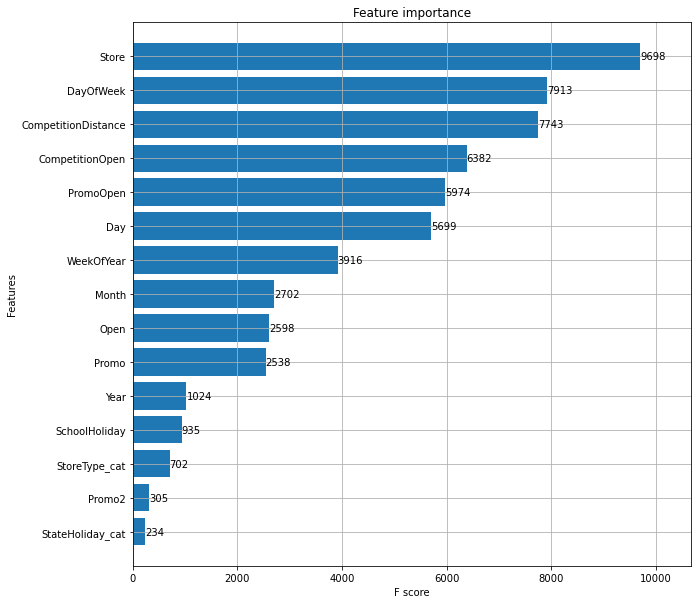

In [58]:
#Feature Importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

Nach dem Tuning konnten wir den RMSE verbessern 

### Vergleich der zwei Modelle

In [59]:
rms_arima = format(float(rms_arima))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "XGBoost"],
    "RMSE": [rms_arima, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
1,XGBoost,1193.4243877534664
0,SARIMA,739.0611703774467


SARIMA performt am besten, in dem Case! (Macht Sinn, SARIMA's Stärke ist in sais. Zeitreihen)